**В ДАННОМ БЛОКНОТЕ *ИССЛЕДУЕТСЯ* МЕТОД ОБНАРУЖЕНИЯ АНОМАЛИЙ СЕТЕВОГО ТРАФИКА НА ОСНОВЕ СТАТИСТИЧЕСКИХ ХАРАКТЕРИСТИК С ИСПОЛЬЗОВАНИЕМ МЕТОДОВ МАШИННОГО ОБУЧЕНИЯ

Основная суть идеи заключается в поиске корреляционных связей между временными рядами характеристик нормального и аномального сетевого трафика.
Работа производится на **размеченных данных**

Краткий алгоритм работы по шагам:
1. Загружаем данные из pcap в csv с выделением **значимых** характеристик сетевого трафика (конвертер лежит совместно с блокнотом)
2. Загружаем csv в блокнот
3. Агрегируем в первый раз, смотрим графики
4. Скользящим временным окном проходим по агрегированным данным, на каждом окне считаем статистические характеристики
5. Записываем все в csv
6. Смотрим как методы машинного обучения справляются с разделением заранее классифицированных данных, проводим анализ

In [1]:
### ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК
from pivottablejs import pivot_ui
import plotly as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import rcParams
import csv
import blah
import warnings
from progress.bar import IncrementalBar
from tqdm import tqdm
from pycaret.classification import *
from sklearn.utils import shuffle
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 8, 5


from ipywidgets import IntProgress
from IPython.display import display
import time
from IPython.display import display
from ipywidgets import Button, Layout, FloatSlider, RadioButtons

In [2]:
# ИНИЦИАЛИЗАЦИЯ КЛАССА, В КОТОРЫЙ СОХРАНЯЕТСЯ CSV ФАЙЛ 

class Packet:
    def __init__(self,time,time_delta,time_delta_disp,time_relative, \
                time_epoch, length,ip_src, ip_dst,df, mf, rb, src_port, dst_port, \
                ack, syn , fin, clas):
        self.time = time
        self.time_delta = time_delta
        self.time_delta_disp = time_delta_disp
        self.time_relative = time_relative
        self.time_epoch = time_epoch
        self.length = length
        self.ip_src = ip_src
        self.ip_dst = ip_dst
        self.df = df
        self.mf = mf
        self.rb = rb
        self.src_port = src_port
        self.dst_port = dst_port
        self.ack = ack
        self.syn = syn
        self.fin = fin
        self.clas = clas
        
    def __repr__(self):
        return "В этом классе содержатся поля пакета"

        
    def __str__(self):
        return "В этом классе содержатся поля пакета"
    

### ИНИЦИАЛИЗАЦИЯ КЛАССА, ЭКЗЕМПЛЯРЫ КОТОРОГО БУДУТ ОТВЕЧАТЬ ЗА ХАРАКТЕРИСТИКИ 
### ПАКЕТОВ НА ИНТЕРВАЛАХ


class Interval:
    def __init__(self, length, mean_length, min_length, max_length,\
                intens, syn, ack, fin, unique_ip, intens_bit, ip_src, ip_dst, \
                src_port, dst_port, classification, unique_port):
        self.length = length
        self.mean_length = mean_length
        self.min_length = min_length
        self.max_length = max_length
        self.intens = intens
        self.syn = syn
        self.ack = ack
        self.fin = fin
        self.unique_ip = unique_ip
        self.intens_bit = intens_bit
        self.ip_src = ip_src
        self.ip_dst = ip_dst
        self.src_port = src_port
        self.dst_port = dst_port
        self.classification = classification
        self.unique_port = unique_port
        
        def __repr__(self):
            return "Экзмепляры этого класса отвечают за поля пакета на интервалах наблюдения"

        
        def __str__(self):
            return "Экзмепляры этого класса отвечают за поля пакета на интервалах наблюдения"    

In [3]:
### ЧТЕНИЕ CSV ФАЙЛА В КЛАСС Packet

array_object_of_Packet = []
button1 = Button(description="Загрузка исходных данных", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked(b):
    try:
        global filename
        fn = blah.gui_fname()
        len_of_csv = len(open(fn).readlines())
        filename = fn
        print("ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ")
        prgBar1 = IntProgress(min = 0, max = len_of_csv) # Создаем прогрессбар
        display(prgBar1)
        with open(filename, encoding='utf-8') as r_file:
            file_reader = csv.reader(r_file, delimiter=',')
            count = 0
            for row in file_reader:
                prgBar1.value += count
                if count != 0:
                    a = Packet(row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], \
                              row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], \
                              row[16])
                    array_object_of_Packet.append(a)
                    count += 1
                    del a
                else: 
                    count += 1
            print(f'____________________________________________________________________')
            print("ЗАГРУЗКА ЗАВЕРШЕНА")
            print(f'{filename} содержит {count} записей')
            print(f'Все данные загружены в массив объектов класса array_object_of_packet')
            print(f'____________________________________________________________________')
    except Exception as e:
        print(f'____________________________________________________________________')
        print('Ошибка в чтении файла, загрузите файл формата csv')
        print(f'____________________________________________________________________')   
# button1.on_click(on_button_clicked) # Назначаем этот обработчик на событие "on_click"
# display(button1)    




In [4]:
### ФУНКЦИЯ ДЛЯ РАСЧЕТА ХАРАКТЕРИСТИК НА ИНТЕРВАЛЕ 
### ВХОД(ЛЕВ.ГР, ПР.ГР, МАССИВ, ШАГ)

def func(left_k, right_k, array, counter):
    ln = []
    bit = []
    syn = []
    ack = []
    fin = []
    ip_src = []
    ip_dst = []
    src_port = []
    dst_port = []
    unique_ip = []
    unique_port = []
    l = 0
    classifica = []
    for i in range(counter , len(array)):
        num = array[i].time_relative
        if left_k <= float(num) <= right_k:
            ln.append(int(array[i].length))
            bit.append(int(array[i].length) * 8)
            if int(array[i].syn) == 1:
                syn.append(1)
            else:
                syn.append(0)
            if int(array[i].fin) == 1:
                fin.append(1)
            else:
                fin.append(0)
            if int(array[i].ack) == 1:
                ack.append(1)
            else:
                ack.append(0)
#             if int(array[i].clas) == 1:
#                 l += 1
            classifica.append(int(array[i].clas))
            ip_src.append(array[i].ip_src)
            ip_dst.append(array[i].ip_dst)
            src_port.append(array[i].src_port)
            dst_port.append(array[i].dst_port)
            unique_ip.append('src: ' + array[i].src_port + \
                          ' dst: ' + array[i].ip_dst)
            unique_port.append('src: ' + array[i].dst_port + \
                          ' dst: ' + array[i].ip_dst)
        if right_k < float(array[i].time_relative):
            break
    if len(classifica) == sum(classifica):
        itog = 1
    else: 
        itog = 0
    classifica.clear()
    return ln, i, syn, ack, fin, ip_src, ip_dst, src_port, dst_port, len(set(unique_ip)), sum(bit), itog, len(set(unique_port))

In [5]:
### ФУНКЦИЯ ДЛЯ ДВИЖЕНИЯ ОКНА ПО МАССИВУ ARRAY_OBJECT_OF_PACKET
button2 = Button(description="Агрегирование исходных данных", button_style='info', layout=Layout(width='50%', height='80px'))
fSlider = FloatSlider(
    value=2.5, # Первоначальное значение
    min=0.1,     # Минимум
    max=6,  # Максимум
    step=0.1,  # Шаг изменения
    description='Параметр:',
    continuous_update=False,  # True - событие observe возникает для каждого шага при изменении значения
    orientation='horizontal'  # Горизонтальное или вертикальное расположение
)

def on_value_change(b):
    pass
#     print(fSlider.value)
    
# fSlider.observe(on_value_change, names='value')
# display(fSlider)

def on_button_clicked2(b):
    try:
        global array_object_on_Interval
    #     k = float(input('Введите интервал -окно- наблюдения '))
        k = fSlider.value
        time.sleep(3)
        array_object_on_Interval = []
        NUMBER = []
        num = 0

        step = k
        k1 = 0
        k2 = k
        cnt = 0
        c = float(array_object_of_Packet[-1].time_relative)
        print("АГРЕГИРОВАНИЕ ИСХОДНЫХ ДАННЫХ")

        prgBar = IntProgress(min = 0, max = c)
        display(prgBar)


        print('Loading:')
        while k1 <= c:
            prgBar.value += k1

            if len(func(k1, k2, array_object_of_Packet, cnt)[0]) != 0:
                b = Interval(func(k1, k2, array_object_of_Packet, cnt)[0],\
                             np.mean(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                             min(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                             max(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                             len(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                             sum(func(k1, k2, array_object_of_Packet, cnt)[2]),\
                             sum(func(k1, k2, array_object_of_Packet, cnt)[3]),\
                             sum(func(k1, k2, array_object_of_Packet, cnt)[4]),\
                             func(k1, k2, array_object_of_Packet, cnt)[9],\
                             func(k1, k2, array_object_of_Packet, cnt)[10],\
                             func(k1, k2, array_object_of_Packet, cnt)[5],\
                             func(k1, k2, array_object_of_Packet, cnt)[6],\
                             func(k1, k2, array_object_of_Packet, cnt)[7],\
                             func(k1, k2, array_object_of_Packet, cnt)[8],\
                             func(k1, k2, array_object_of_Packet, cnt)[11],\
                             func(k1, k2, array_object_of_Packet, cnt)[12])

                array_object_on_Interval.append(b)
                NUMBER.append(num)
                del b
            else:
                NUMBER.append(num)
            cnt = func(k1, k2, array_object_of_Packet, cnt)[1]
            k1, k2 = k1 + step, k2 + step
            num += 1
        print(f'____________________________________________________________________')
        print(f'АГРЕГИРОВАНИЕ ДАННЫХ ПРОШЛО УСПЕШНО')
        print(f'Data -array_object_of_Packet- downloaded with')
        print(f'Window agregation = {k} and step = {step}')
        print(len(array_object_of_Packet))
        print(f'____________________________________________________________________')
    except Exception as e:
        print(f'____________________________________________________________________')
        print(f'ПРОИЗОШЛА ОШИБКА В АГРЕГИРОВАНИИ ДАННЫХ')
        print(f'____________________________________________________________________')
        
# button2.on_click(on_button_clicked2)
# display(button2)


In [6]:
# ### ЗАПИШЕМ ВСЕ ДАННЫЕ В ДАТАФРЕЙМ  -->
button3 = Button(description="Запись данных в массив", button_style='success',layout=Layout(width='50%', height='80px'))

def on_button_clicked3(b):
#     print("ЗАПИСЬ ДАННЫХ В МАССИВ")
    global array_object_on_Interval0, array_object_on_Interval1, Number0, Number1, df
    df = pd.DataFrame(columns=['mean_ln','min_ln','max_ln','intens_p','intens_bit',\
                      'unique_ip','unique_port','syn','fin','ack','classif'])
    len_ar = len(array_object_on_Interval)
    
    bar = IncrementalBar('Countdown', max = len_ar)

    count = 0
    Number0 = []
    Number1 = []
    array_object_on_Interval0 = []
    array_object_on_Interval1 = []
    for x in tqdm(array_object_on_Interval):
        if x.classification == 1:
            array_object_on_Interval1.append(x)
            Number1.append(count)
        else:
            array_object_on_Interval0.append(x)
            Number0.append(count)
        count += 1
        df.loc[len(df)] = [x.mean_length, x.min_length, x.max_length, x.intens,\
                          x.intens_bit, x.unique_ip, x.unique_port, x.syn, x.fin,\
                          x.ack, x.classification] 
    print(len(array_object_on_Interval))
    print(len(array_object_on_Interval0), len(Number0))
    print(len(array_object_on_Interval1), len(Number1))
    # d = pd.DataFrame([[p.mean_length, p.min_length, p.max_length, p.intens] for p in array_object_on_Interval])
    # print(df)
    # df.to_csv('first_wind_agr=2_step=2.csv', sep=',', encoding='utf-8', index=True)
    print(f'____________________________________________________________________')
    print(' ДАННЫЕ ЗАПИСАНЫ В МАССИВ first_wind.csv')
    print(f'____________________________________________________________________')
    
# button3.on_click(on_button_clicked3) # Назначаем этот обработчик на событие "on_click"
# display(button3)

In [7]:
rButtons2 = RadioButtons(
    options=[('mean_ln', 1), ('min_ln', 2), ('max_ln', 3), ('intens_packet', 4), ('syn_flags', 5), ('fin_flags', 6), ('ack_flags', 7), ('unique_ip', 8), ('intens_bit', 9), ('unique_port', 10), ('Взаимная корреляция', 11)],
    value=1, # Выбор по умолчанию
    description='Параметр:' 
)

def on_button_clicked4(b):
    if rButtons2.value == 1:
        #mean_length
        plt.subplot(111)
        plt.bar(Number0, [x.mean_length for x in array_object_on_Interval0])
        plt.bar(Number1, [x.mean_length for x in array_object_on_Interval1], color = 'r')
        # plt.axis([0, len(array_object_on_Interval), 0, 1000])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('mean_Length')
        plt.minorticks_on()

        plt.grid()
        # plt.savefig('./dns/agr2_step2/mean_length.png')
    
    elif rButtons2.value == 2:
        #min_length
        plt.subplot(111)
        plt.bar(Number0, [x.min_length for x in array_object_on_Interval0])
        plt.bar(Number1, [x.min_length for x in array_object_on_Interval1], color = 'r')
        # plt.axis([0, len(array_object_on_Interval), 0, 200])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('min_Length')
        # plt.savefig('./dns/agr2_step2/min_ln.png')
        plt.minorticks_on()

        plt.grid()
    
    elif rButtons2.value == 3:
        #max_length
        plt.subplot(111)
        plt.bar(Number0, [x.max_length for x in array_object_on_Interval0])
        plt.bar(Number1, [x.max_length for x in array_object_on_Interval1], color='r')
        # plt.axis([0, len(array_object_on_Interval), 0, 4000])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('max_Length')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/max_ln.png')
    
    elif rButtons2.value == 4:
        #intens -packet
        plt.subplot(111)
        plt.bar(Number0, [x.intens for x in array_object_on_Interval0])
        plt.bar(Number1, [x.intens for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, intens1, color='r')
        plt.axis([0, len(array_object_on_Interval), 0, 1000])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('intens_packet')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/intens_p.png')
    elif rButtons2.value == 5:
        #syn_flags
        plt.subplot(111)
        plt.bar(Number0, [x.syn for x in array_object_on_Interval0])
        plt.bar(Number1, [x.syn for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, syn1, color= 'r')
        plt.axis([0, len(array_object_on_Interval), 0, 40])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('syn_flags')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/syn.png')
    elif rButtons2.value == 6:
        #fin_flags
        plt.subplot(111)
        plt.bar(Number0, [x.fin for x in array_object_on_Interval0])
        plt.bar(Number1, [x.fin for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, syn1, color= 'r')
        plt.axis([0, len(array_object_on_Interval), 0, 40])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('fin_flags')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/fin.png')
    elif rButtons2.value == 7:
        #ack_flags
        plt.subplot(111)
        plt.bar(Number0, [x.ack for x in array_object_on_Interval0])
        plt.bar(Number1, [x.ack for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, syn1, color= 'r')
        plt.axis([0, len(array_object_on_Interval), 0, 400])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('ack_flags')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/ack.png')
    elif rButtons2.value == 8:
        #unique ip-ip
        plt.subplot(111)
        plt.bar(Number0, [x.unique_ip for x in array_object_on_Interval0])
        plt.bar(Number1, [x.unique_ip for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, unique1, color='r')
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('unique ip - ip')
        plt.minorticks_on()
        plt. axis([0, len(array_object_on_Interval), 0, 70])
        plt.grid()
        # plt.savefig('./dns/agr2_step2/unique_ip.png')
    elif rButtons2.value == 9:
        #intens_bit
        plt.subplot(111)
        plt.bar(Number0, [x.intens_bit for x in array_object_on_Interval0])
        plt.bar(Number1, [x.intens_bit for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, bit1, color='r')
        # plt.axis([0, len(array_object_on_Interval), 0, 400000])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('intense_bit')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/intens_bit.png')
    elif rButtons2.value == 10:
        #unique_port
        plt.subplot(111)
        plt.bar(Number0, [x.unique_port for x in array_object_on_Interval0])
        plt.bar(Number1, [x.unique_port for x in array_object_on_Interval1], color='r')
        # plt.bar(NUMBER1, bit1, color='r')
        plt.axis([0, len(array_object_on_Interval), 0, 70])
        plt.xlabel('Отсчет')
        plt.ylabel('ss')
        plt.title('unique_port-port')
        plt.minorticks_on()
        plt.grid()
        # plt.savefig('./dns/agr2_step2/unique_port.png')
    else:
        import seaborn as sns
        cols = ['classif', 'mean_ln', 'intens_p', 'unique_ip', 'min_ln', 'unique_port']
        sns_plot = sns.pairplot(df[cols], hue='classif')
        pivot_ui(df)

    return plt.show()

        
# rButtons2.observe(on_button_clicked4, names='value')
# display(rButtons2)

In [8]:
#### коэффициент ассметрии

def koef_assim(a):
    d = np.var(a, ddof=1)
    ka = (sum((xi - np.mean(a)) ** 3 for xi in a) / len(a)) / d ** 3
    if np.isnan(ka) or np.isinf(ka):
        return 0 
    return ka

#### коэффициент эксцесса

def koef_eksces(a):
    d = np.var(a, ddof=1)
    ke = ((sum((xi - np.mean(a)) ** 4 for xi in a) / len(a)) / d ** 4) - 3
    if np.isnan(ke) or np.isinf(ke):
        return 0 
    return ke

#### контрэксцесс

def kontrecsces(a):
    d = np.var(a, ddof=1)
    c = 1 / math.sqrt(scipy.stats.moment(a, moment=4) / (math.sqrt(d) ** 4))
    if np.isnan(c) or np.isinf(c):
        return 0
    return c
#### энтропийный коэффициент

def entr_koef(d, n, y, a):
    # n = len(a) число элементов в списке
    # m = int(10 + np.sqrt(n)) кол интервалов разбиения
    # d =(max(a)-min(a))/m длина интервалов
    h = 0.5 * d * n * 10 ** (-1 * (y * math.log10(y) / n))
    
#     h = 0.5 * d * n * 10 ** (-sum ([w * math.log10 (w) for w in y if w != 0]) / n)
    h = h / a
    if np.isnan(h) or np.isinf(h):
        return 0 
    return h

In [9]:
### создание класса для 4-х функций у каждого парамерта
class Default:
    def __init__(self, mean_ln_k_assim, mean_ln_k_eks, mean_ln_kontr, mean_ln_en_k,\
                min_ln_k_assim, min_ln_k_eks, min_ln_kontr, min_ln_en_k,\
                max_ln_k_assim, max_ln_k_eks, max_ln_kontr, max_ln_en_k,\
                intens_bit_k_assim, intens_bit_k_eks, intens_bit_kontr, intens_bit_en_k, \
                intens_p_k_assim, intens_p_k_eks, intens_p_kontr, intens_p_en_k,\
                unique_ip_k_assim, unique_ip_k_eks, unique_ip_kontr, unique_ip_en_k, \
                unique_port_k_assim, unique_port_k_eks, unique_port_kontr, unique_port_en_k, classific):
        self.mean_ln_k_assim = mean_ln_k_assim
        self.mean_ln_k_eks = mean_ln_k_eks
        self.mean_ln_kontr = mean_ln_kontr
        self.mean_ln_en_k = mean_ln_en_k
        
        self.min_ln_k_assim = min_ln_k_assim
        self.min_ln_k_eks = min_ln_k_eks
        self.min_ln_kontr = min_ln_kontr
        self.min_ln_en_k = min_ln_en_k
    
        self.max_ln_k_assim = max_ln_k_assim
        self.max_ln_k_eks = max_ln_k_eks
        self.max_ln_kontr = max_ln_kontr
        self.max_ln_en_k = max_ln_en_k
        
        self.intens_bit_k_assim = intens_bit_k_assim
        self.intens_bit_k_eks = intens_bit_k_eks
        self.intens_bit_kontr = intens_bit_kontr
        self.intens_bit_en_k = intens_bit_en_k
        
        self.intens_p_k_assim = intens_p_k_assim
        self.intens_p_k_eks = intens_p_k_eks
        self.intens_p_kontr = intens_p_kontr
        self.intens_p_en_k = intens_p_en_k
        
        self.unique_ip_k_assim = unique_ip_k_assim
        self.unique_ip_k_eks = unique_ip_k_eks
        self.unique_ip_kontr = unique_ip_kontr
        self.unique_ip_en_k = unique_ip_en_k
        
        self.unique_port_k_assim = unique_port_k_assim
        self.unique_port_k_eks = unique_port_k_eks
        self.unique_port_kontr = unique_port_kontr
        self.unique_port_en_k = unique_port_en_k
        
        self.classific = classific

#создание каждого объекта отдельно



In [10]:
import scipy.stats

def func2(k1, k2, array):
#     obj = Default(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
#     del obj
    f_mean_length = []
    f_min_len = []
    f_max_len = []
    f_intens_bit = []
    f_intens_p = []
    f_unique_ip = []
    f_unique_port = []
    f_class = []
    itog_cl = []
    for i in range(len(array)):
        if int(k1) <= int(i) <= int(k2):
            f_mean_length.append(array[i].mean_length)
            f_min_len.append(array[i].min_length)
            f_max_len.append(array[i].max_length)
            f_intens_bit.append(array[i].intens_bit)
            f_intens_p.append(array[i].intens)
            f_unique_ip.append(array[i].unique_ip)
            f_unique_port.append(array[i].unique_port) 
            f_class.append(array[i].classification)
    if len(f_mean_length) > 0:
        if len(f_class) == sum(f_class):
            itog_cl = 1
        else:
            itog_cl = 0
        obj = Default(koef_assim(f_mean_length), koef_eksces(f_mean_length), kontrecsces(f_mean_length),\
                      entr_koef(k2 - k1, len(f_mean_length), len(f_mean_length), np.std(f_mean_length)),\
                      koef_assim(f_min_len), koef_eksces(f_min_len), kontrecsces(f_min_len),\
                      entr_koef(k2 - k1, len(f_min_len), len(f_min_len), np.std(f_min_len)), \
                      koef_assim(f_max_len), koef_eksces(f_max_len), kontrecsces(f_max_len), \
                      entr_koef(k2 - k1, len(f_max_len), len(f_max_len), np.std(f_max_len)), \
                      koef_assim(f_intens_bit), koef_eksces(f_intens_bit), kontrecsces(f_intens_bit), \
                      entr_koef(k2 - k1, len(f_intens_bit), len(f_intens_bit), np.std(f_intens_bit)), \
                      koef_assim(f_intens_p), koef_eksces(f_intens_p), kontrecsces(f_intens_p), \
                      entr_koef(k2 - k1, len(f_intens_p), len(f_intens_p), np.std(f_intens_p)), \
                      koef_assim(f_unique_ip), koef_eksces(f_unique_ip), kontrecsces(f_unique_ip), \
                      entr_koef(k2 - k1, len(f_unique_ip), len(f_unique_ip), np.std(f_unique_ip)), \
                      koef_assim(f_unique_port), koef_eksces(f_unique_port), kontrecsces(f_unique_port), \
                      entr_koef(k2 - k1, len(f_unique_port), len(f_unique_port), np.std(f_unique_port)),\
                      itog_cl)            
            
    else:
        pass
    f_mean_length.clear()
    f_min_len.clear()
    f_max_len.clear()
    f_intens_bit.clear()
    f_intens_p.clear()
    f_unique_ip.clear()
    f_unique_port.clear()
    f_class.clear()
    return obj


In [11]:
def fff(a1, a2, arr):
    global dff
    prgBar2 = IntProgress(min = 0, max = len(arr)) # Создаем прогрессбар
    display(prgBar2)
    ITOG_MAS = []
    c = len(arr)
    while a2 <= len(arr):
        prgBar2.value += step2
        ITOG_MAS.append(func2(a1, a2, arr))
        a1, a2 = a1 + step2, a2 + step2
        dff = pd.DataFrame([[p.mean_ln_k_assim, p.mean_ln_k_eks, p.mean_ln_kontr, p.mean_ln_en_k,\
                        p.min_ln_k_assim, p.min_ln_k_eks, p.min_ln_kontr, p.min_ln_en_k, \
                        p.max_ln_k_assim, p.max_ln_k_eks, p.max_ln_kontr, p.max_ln_en_k, \
                        p.intens_p_k_assim, p.intens_p_k_eks, p.intens_p_kontr, p.intens_p_en_k,\
                        p.intens_bit_k_assim, p.intens_bit_k_eks, p.intens_bit_kontr, p.intens_bit_en_k,\
                        p.unique_port_k_assim, p.unique_port_k_eks, p.unique_port_kontr, p.unique_port_en_k,\
                        p.unique_ip_k_assim, p.unique_ip_k_eks, p.unique_ip_kontr, p.unique_ip_en_k, p.classific
                        ] for p in ITOG_MAS],
                      columns=['mean_ln_k_assim', 'mean_ln_k_eks', 'mean_ln_kontr', 'mean_ln_en_k',
                               'min_ln_k_assim', 'min_ln_k_eks', 'min_ln_kontr', 'min_ln_en_k',
                               'max_ln_k_assim', 'max_ln_k_eks', 'max_ln_kontr', 'max_ln_en_k',
                               'intens_p_k_assim', 'intens_p_k_eks', 'intens_p_kontr', 'intens_p_en_k',
                               'intens_bit_k_assim', 'intens_bit_k_eks', 'intens_bit_kontr', 'intens_bit_en_k',
                               'unique_ip_k_assim', 'unique_ip_k_eks', 'unique_ip_kontr', 'unique_ip_en_k',
                               'unique_port_k_assim', 'unique_port_k_eks', 'unique_port_kontr', 'unique_port_en_k',
                               'classif'])
    dff.to_csv('last.csv', sep=',', encoding='utf-8', index=False)
    print('csv created')
    return ITOG_MAS, dff
    

In [12]:
fSlider1 = FloatSlider(
    value=3, # Первоначальное значение
    min=1,     # Минимум
    max=10.0,  # Максимум
    step=1,  # Шаг изменения
    description='Window:',
    continuous_update=False,  # True - событие observe возникает для каждого шага при изменении значения
    orientation='horizontal'  # Горизонтальное или вертикальное расположение
)
fSlider2 = FloatSlider(
    value=1, # Первоначальное значение
    min=1,     # Минимум
    max=4,  # Максимум
    step=1,  # Шаг изменения
    description='Step:',
    continuous_update=False,  # True - событие observe возникает для каждого шага при изменении значения
    orientation='horizontal'  # Горизонтальное или вертикальное расположение
)
def on_value_change(b):
    pass
# a1 = 0
# a2 = int(input('Введите окно для анализа временного интервала = '))
# step2 = int(input('Введите шаг окна = '))

button4 = Button(description="Обработка данных методом скользящего временного окна",button_style='success',layout=Layout(width='50%', height='80px'))
def on_button_clicked5(b): # Описываем обработчик события
    global NUM0, NUM1, itog_mas0, itog_mas1, a1, a2, step2
    a1 = 0
    a2 = fSlider1.value
    step2 = fSlider2.value
    itog_mas0 = []
    NUM0 = []
    itog_mas1 = []
    NUM1 = []
    l = fff(a1,a2,array_object_on_Interval)
    k = l[0]
    dff = l[1]
    cnt = 0
    for c in k:
        if c.classific == 0:
            itog_mas0.append(c)
            NUM0.append(cnt)
        else:
            itog_mas1.append(c)
            NUM1.append(cnt)
        cnt += 1

    print(f'интервал = {a2}')
    print(f'шаг = {step2}')
    print(f'Объектов с классом 0 : {len(itog_mas0)}')
    print(f'Объектов с классом 1 : {len(itog_mas1)}')
    print(f'____________________________________________________________________')
    return NUM0, NUM1, itog_mas0, itog_mas1

fSlider1.observe(on_value_change, names='value')
display(fSlider1)
fSlider2.observe(on_value_change, names='value')
display(fSlider2)
button4.on_click(on_button_clicked5) # Назначаем этот обработчик на событие "on_click"

display(button4)
# print(len(dff))

FloatSlider(value=3.0, continuous_update=False, description='Window:', max=10.0, min=1.0, step=1.0)

FloatSlider(value=1.0, continuous_update=False, description='Step:', max=4.0, min=1.0, step=1.0)

Button(button_style='success', description='Обработка данных методом скользящего временного окна', layout=Layo…

In [13]:
# print ('ГРАФИКИ ДЛЯ СРЕДНЕЙ ДЛИНЫ ПАКЕТА')
button6 = Button(description="Графики для средней длины пакета", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked6(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.mean_ln_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.mean_ln_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.0005, 0.0005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.mean_ln_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.mean_ln_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM0, [c.mean_ln_kontr for c in itog_mas0])
    plt.bar(NUM1, [c.mean_ln_kontr for c in itog_mas1], color='r')
    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.mean_ln_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.mean_ln_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    plt.axis([0, len(NUM0) + len(NUM1), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.mean_ln_en_k for c in itog_mas1], [c.mean_ln_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.mean_ln_en_k for c in itog_mas0], [c.mean_ln_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.mean_ln_k_assim**2 for c in itog_mas1], [c.mean_ln_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.mean_ln_k_assim**2 for c in itog_mas0], [c.mean_ln_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.mean_ln_kontr for c in itog_mas1], [c.mean_ln_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.mean_ln_kontr for c in itog_mas0], [c.mean_ln_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.mean_ln_en_k for c in itog_mas0], y=[c.mean_ln_k_assim for c in itog_mas0],\
                        z=[c.mean_ln_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.mean_ln_en_k for c in itog_mas1], y=[c.mean_ln_k_assim for c in itog_mas1],\
                        z=[c.mean_ln_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))
button6.on_click(on_button_clicked6) # Назначаем этот обработчик на событие "on_click"

display(button6) 

Button(button_style='success', description='Графики для средней длины пакета', layout=Layout(height='80px', wi…

In [14]:
print ('ГРАФИКИ ДЛЯ МАКСИМАЛЬНОЙ ДЛИНЫ ПАКЕТА')
button7 = Button(description="Графики для максимальной длины пакета", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked7(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.max_ln_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.max_ln_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.max_ln_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.max_ln_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.max_ln_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.max_ln_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.max_ln_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.max_ln_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.max_ln_en_k for c in itog_mas1], [c.max_ln_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.max_ln_en_k for c in itog_mas0], [c.max_ln_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.max_ln_k_assim**2 for c in itog_mas1], [c.max_ln_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.max_ln_k_assim**2 for c in itog_mas0], [c.max_ln_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.max_ln_kontr for c in itog_mas1], [c.max_ln_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.max_ln_kontr for c in itog_mas0], [c.max_ln_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.max_ln_en_k for c in itog_mas0], y=[c.max_ln_k_assim for c in itog_mas0],\
                        z=[c.max_ln_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.max_ln_en_k for c in itog_mas1], y=[c.max_ln_k_assim for c in itog_mas1],\
                        z=[c.max_ln_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))
# button7.on_click(on_button_clicked7) # Назначаем этот обработчик на событие "on_click"

# display(button7) 

ГРАФИКИ ДЛЯ МАКСИМАЛЬНОЙ ДЛИНЫ ПАКЕТА


In [15]:
print ('ГРАФИКИ ДЛЯ МИНИМАЛЬНОЙ ДЛИНЫ ПАКЕТА')
button8 = Button(description="Графики для минимальной длины пакета", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked8(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.min_ln_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.min_ln_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.min_ln_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.min_ln_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.min_ln_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.min_ln_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.min_ln_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.min_ln_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.min_ln_en_k for c in itog_mas1], [c.min_ln_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.min_ln_en_k for c in itog_mas0], [c.min_ln_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.min_ln_k_assim**2 for c in itog_mas1], [c.min_ln_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.min_ln_k_assim**2 for c in itog_mas0], [c.min_ln_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.min_ln_kontr for c in itog_mas1], [c.min_ln_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.min_ln_kontr for c in itog_mas0], [c.min_ln_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.min_ln_en_k for c in itog_mas0], y=[c.min_ln_k_assim for c in itog_mas0],\
                        z=[c.min_ln_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.min_ln_en_k for c in itog_mas1], y=[c.min_ln_k_assim for c in itog_mas1],\
                        z=[c.min_ln_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))
# button8.on_click(on_button_clicked8) # Назначаем этот обработчик на событие "on_click"

# display(button8) 

ГРАФИКИ ДЛЯ МИНИМАЛЬНОЙ ДЛИНЫ ПАКЕТА


In [16]:
print ('ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ АДРЕСОВ АЙПИ ПАКЕТА')

button9 = Button(description="Графики для уникальных адресов ip пакета", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked9(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_ip_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_ip_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.05, 0.05])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_ip_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_ip_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_ip_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_ip_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_ip_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_ip_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.unique_ip_en_k for c in itog_mas1], [c.unique_ip_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.unique_ip_en_k for c in itog_mas0], [c.unique_ip_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.unique_ip_k_assim**2 for c in itog_mas1], [c.unique_ip_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.unique_ip_k_assim**2 for c in itog_mas0], [c.unique_ip_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.unique_ip_kontr for c in itog_mas1], [c.unique_ip_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.unique_ip_kontr for c in itog_mas0], [c.unique_ip_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.unique_ip_en_k for c in itog_mas0], y=[c.unique_ip_k_assim for c in itog_mas0],\
                        z=[c.unique_ip_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.unique_ip_en_k for c in itog_mas1], y=[c.unique_ip_k_assim for c in itog_mas1],\
                        z=[c.unique_ip_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))
    
# button9.on_click(on_button_clicked9) # Назначаем этот обработчик на событие "on_click"

# display(button9) 

ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ АДРЕСОВ АЙПИ ПАКЕТА


In [17]:
print ('ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ ПОРТОВ АЙПИ ПАКЕТА')

button10 = Button(description="Графики для уникальных портов ip пакета", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked10(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_port_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_port_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_port_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_port_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_port_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_port_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.unique_port_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.unique_port_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.unique_port_en_k for c in itog_mas1], [c.unique_port_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.unique_port_en_k for c in itog_mas0], [c.unique_port_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.unique_port_k_assim**2 for c in itog_mas1], [c.unique_port_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.unique_port_k_assim**2 for c in itog_mas0], [c.unique_port_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.unique_port_kontr for c in itog_mas1], [c.unique_port_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.unique_port_kontr for c in itog_mas0], [c.unique_port_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.unique_port_en_k for c in itog_mas0], y=[c.unique_port_k_assim for c in itog_mas0],\
                        z=[c.unique_port_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.unique_port_en_k for c in itog_mas1], y=[c.unique_port_k_assim for c in itog_mas1],\
                        z=[c.unique_port_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))
# button10.on_click(on_button_clicked10) # Назначаем этот обработчик на событие "on_click"

# display(button10) 

ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ ПОРТОВ АЙПИ ПАКЕТА


In [18]:
print ('ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ ПАКЕТ')
button11 = Button(description="Графики для интенсивности пакетов", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked11(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_p_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_p_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_p_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_p_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_p_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_p_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_p_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_p_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.intens_p_en_k for c in itog_mas1], [c.intens_p_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.intens_p_en_k for c in itog_mas0], [c.intens_p_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.intens_p_k_assim**2 for c in itog_mas1], [c.intens_p_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.intens_p_k_assim**2 for c in itog_mas0], [c.intens_p_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.intens_p_kontr for c in itog_mas1], [c.intens_p_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.intens_p_kontr for c in itog_mas0], [c.intens_p_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.intens_p_en_k for c in itog_mas0], y=[c.intens_p_k_assim for c in itog_mas0],\
                        z=[c.intens_p_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.intens_p_en_k for c in itog_mas1], y=[c.intens_p_k_assim for c in itog_mas1],\
                        z=[c.intens_p_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=False,
                         filename=("3DPlot.html"))



# button11.on_click(on_button_clicked11) # Назначаем этот обработчик на событие "on_click"

# display(button11) 

ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ ПАКЕТ


In [19]:
print ('ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ БИТ')
button12 = Button(description="Графики для интенсивности бит", button_style='success', layout=Layout(width='50%', height='80px'))

def on_button_clicked12(b):
    #ассиметрия
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_bit_k_assim for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_bit_k_assim for c in itog_mas0])

    plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Ассиметрия')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    #эксцесс
    # print(k_ek_ln)
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_bit_k_eks for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_bit_k_eks for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Эксцесса')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    #
    # #контрэксцесс
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_bit_kontr for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_bit_kontr for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Контр Эксцесс')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтропийный коэф
    # #
    plt.subplot(111)
    plt.bar(NUM1, [c.intens_bit_en_k for c in itog_mas1], color='r')
    plt.bar(NUM0, [c.intens_bit_en_k for c in itog_mas0])

    # plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
    # plt.axis([0, len(range(len(k))), 0, 0.8])
    plt.xlabel('Отсчет')
    plt.ylabel('ss')
    plt.title('Энтропийный коэф')
    plt.minorticks_on()
    plt.grid()
    plt.show()
    # #
    # #энтр коэф \ контр
    # #
    plt.subplot(111)
    plt.title('entr_k / kontr')
    plt.plot([c.intens_bit_en_k for c in itog_mas1], [c.intens_bit_kontr for c in itog_mas1] , 'r^')
    plt.plot([c.intens_bit_en_k for c in itog_mas0], [c.intens_bit_kontr for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
    plt.xlabel('entr_K')
    plt.ylabel('kontr')
    plt.show()
    # #
    # #ассим \ экс
    # #
    plt.subplot(111)
    plt.title('k_assim*2 / k_eks')
    plt.plot( [c.intens_bit_k_assim**2 for c in itog_mas1], [c.intens_bit_k_eks for c in itog_mas1], 'r^')
    plt.plot( [c.intens_bit_k_assim**2 for c in itog_mas0], [c.intens_bit_k_eks for c in itog_mas0], 'b*')

    # plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
    plt.xlabel('k_assim**2')
    plt.ylabel('k_eks')
    plt.show()
    # #
    # #kont/entr
    # #

    plt.subplot(111)
    plt.title('kontr / entr_k')
    plt.xlabel('kontr')
    plt.ylabel('entr_k')
    plt.plot([c.intens_bit_kontr for c in itog_mas1], [c.intens_bit_en_k for c in itog_mas1] , 'r^')
    plt.plot([c.intens_bit_kontr for c in itog_mas0], [c.intens_bit_en_k for c in itog_mas0] , 'b*')

    # plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
    plt.show()
    # #
    import plotly.graph_objs as go
    import plotly
    fig1 = go.Scatter3d(x=[c.intens_bit_en_k for c in itog_mas0], y=[c.intens_bit_k_assim for c in itog_mas0],\
                        z=[c.intens_bit_kontr for c in itog_mas0],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    fig2 = go.Scatter3d(x=[c.intens_bit_en_k for c in itog_mas1], y=[c.intens_bit_k_assim for c in itog_mas1],\
                        z=[c.intens_bit_kontr for c in itog_mas1],\
                        marker=dict(opacity=0.9, reversescale=True,size=5),\
                        line=dict(width=0.2), mode='markers')
    mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                    yaxis=dict( title="k_assim"),
                                    zaxis=dict(title="kontr")),)

    #Plot and save html
    plotly.offline.plot({"data": [fig1, fig2],
                         "layout": mylayout},
                         auto_open=True,
                         filename=("3DPlot.html"))



# button12.on_click(on_button_clicked12) # Назначаем этот обработчик на событие "on_click"

# display(button12) 


ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ БИТ


In [43]:
###  создание pycaret данных

button13 = Button(description='Использование pycaret', button_style='success',
           layout=Layout(width='50%', height='80px'))
def on_button_clicked13(b):
    try: 
        global dataset

        # dff = pd.read_csv('last.csv')
        dataset = dff
        dataset = shuffle(dataset)
            # print(dataset)

            # print(dataset.shape)
        data = dataset.sample(frac=0.6, random_state=1234567)
        data_unseen = dataset.drop(data.index)

        data.reset_index(drop=True, inplace=True)
        data_unseen.reset_index(drop=True, inplace=True)

        print('Data for Modeling: ' + str(data.shape))
        print('Unseen Data For Predictions: ' + str(data_unseen.shape))
        exp1 = setup(dff, target="classif")
        compare_models(fold=4)
    except:
        compare_models(fold=4)
  
# button13.on_click(on_button_clicked13) # Назначаем этот обработчик на событие "on_click"

# display(button13)   

In [21]:
### ИСпользование опорных векторов
button14 = Button(description="Использование методов SVM", 
                        button_style='success', layout=Layout(width='50%', height='80px'))
def on_button_clicked14(b):
    svm1 = create_model('svm', fold=7)
    svm1 = tune_model(svm1)
    # bagged_svm1 = ensemble_model(svm1)
    print(svm1)
    evaluate_model(svm1)
    svm_pred = predict_model(svm1)

In [22]:
### ИСпользование случайного леса
button15 = Button(description="Использование методов RF", 
                        button_style='success', layout=Layout(width='50%', height='80px'))
def on_button_clicked15(b):
    rf = create_model('rf', cross_validation=True)
    rf = tune_model(rf)
    bagged_rf = ensemble_model(rf)
    # print(bagged_rf)
    evaluate_model(rf)
    rf_pred = predict_model(rf)

In [23]:
### ИСпользование случайного леса
button16 = Button(description="Использование методов KNN", 
                        button_style='success', layout=Layout(width='50%', height='80px'))
def on_button_clicked16(b):
    knn = create_model('knn',fold=5)
    knn = tune_model(knn)
    bagged_knn = ensemble_model(knn)
    print(knn)
    evaluate_model(knn)
    knn_pred = predict_model(knn)

In [24]:
### ИСпользование случайного леса
button17 = Button(description="Использование методов DT", 
                        button_style='success', layout=Layout(width='50%', height='80px'))
def on_button_clicked17(b):
    td = create_model('dt')
    td = tune_model(td)
    bagged_td = ensemble_model(td)
    print(td)
    evaluate_model(td)
    td_pred = predict_model(td)

In [25]:
# import seaborn as sns
# mas = input('vvedite_nazv_mas: ')
# assim = mas + '_k_assim'
# eks = mas +'_k_eks'
# kontr = mas +'_kontr'
# en_k = mas + '_en_k'
# cols = [assim, eks, kontr, en_k, 'classif']
# # cols = ['mean_ln_k_assim', 'mean_ln_en_k', 'unique_port_k_assim', 'unique_port_en_k','classif']
# sns_plot = sns.pairplot(dff[cols], hue='classif')
# # sns_plot.savefig('./dns/agr2_step2/agr4_step1/pairplot_unique_port.png')

# ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ

In [65]:
button1.on_click(on_button_clicked) 
display(button1)

Button(button_style='success', description='Загрузка исходных данных', layout=Layout(height='80px', width='50%…

ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ


IntProgress(value=0, max=860789)

____________________________________________________________________
ЗАГРУЗКА ЗАВЕРШЕНА
b'/home/oem/PycharmProjects/converter/csv/norm+dns2tcptunnel.csv' содержит 860789 записей
Все данные загружены в массив объектов класса array_object_of_packet
____________________________________________________________________


# АГРЕГИРОВАНИЕ ИСХОДНЫХ ДАННЫХ И ЗАПИСЬ ДАННЫХ В МАССИВ

In [66]:
fSlider.observe(on_value_change, names='value')
display(fSlider)
button2.on_click(on_button_clicked2)
display(button2)
button3.on_click(on_button_clicked3) 
display(button3)

FloatSlider(value=0.9, continuous_update=False, description='Параметр:', max=6.0, min=0.1)

Button(button_style='info', description='Агрегирование исходных данных', layout=Layout(height='80px', width='5…

Button(button_style='success', description='Запись данных в массив', layout=Layout(height='80px', width='50%')…

АГРЕГИРОВАНИЕ ИСХОДНЫХ ДАННЫХ


IntProgress(value=0, max=3263)

Loading:
____________________________________________________________________
АГРЕГИРОВАНИЕ ДАННЫХ ПРОШЛО УСПЕШНО
Data -array_object_of_Packet- downloaded with
Window agregation = 1.5 and step = 1.5
3806964
____________________________________________________________________


100%|██████████| 2173/2173 [00:02<00:00, 750.95it/s]

2173
2124 2124
49 49
____________________________________________________________________
 ДАННЫЕ ЗАПИСАНЫ В МАССИВ first_wind.csv
____________________________________________________________________


# ПОСТРОЕНИЕ ГРАФИКОВ

RadioButtons(description='Параметр:', index=7, options=(('mean_ln', 1), ('min_ln', 2), ('max_ln', 3), ('intens…

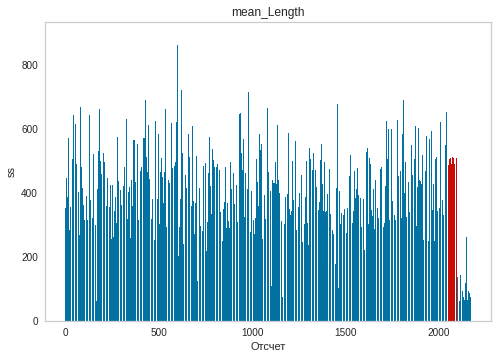

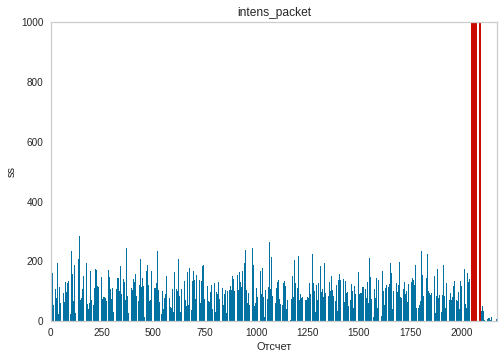

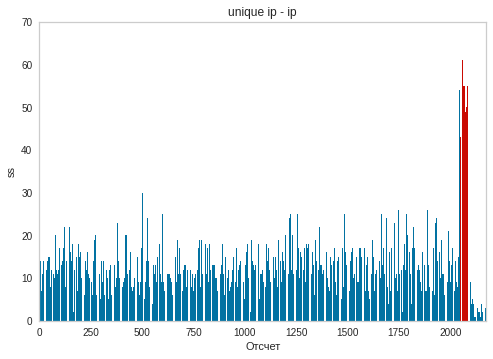

In [67]:
rButtons2.observe(on_button_clicked4, names='value')
display(rButtons2)

# МЕТОД СКОЛЬЗЯЩЕГО ВРЕМЕННОГО ОКНА

In [68]:
fSlider1.observe(on_value_change, names='value')
display(fSlider1)
fSlider2.observe(on_value_change, names='value')
display(fSlider2)
button4.on_click(on_button_clicked5) 
display(button4)

FloatSlider(value=4.0, continuous_update=False, description='Window:', max=10.0, min=1.0, step=1.0)

FloatSlider(value=2.0, continuous_update=False, description='Step:', max=4.0, min=1.0, step=1.0)

Button(button_style='success', description='Обработка данных методом скользящего временного окна', layout=Layo…

IntProgress(value=0, max=2173)

csv created
интервал = 5.0
шаг = 2.0
Объектов с классом 0 : 1063
Объектов с классом 1 : 22
____________________________________________________________________


# ГРАФИКИ ДЛЯ СРЕДНЕЙ ДЛИНЫ ПАКЕТА

Button(button_style='success', description='Графики для средней длины пакета', layout=Layout(height='80px', wi…

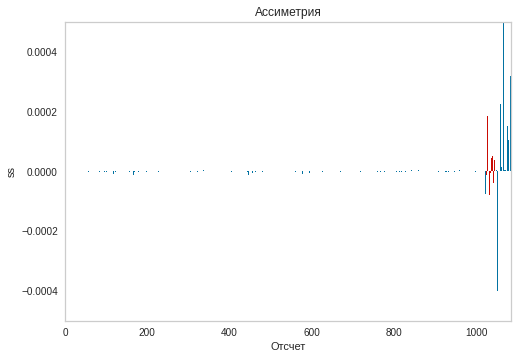

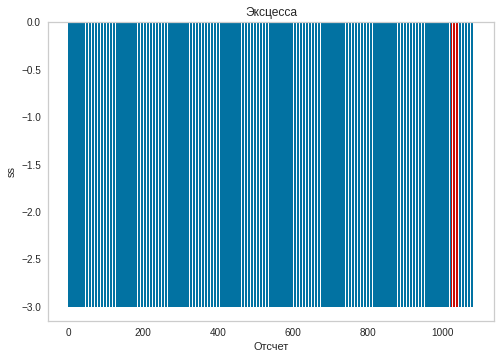

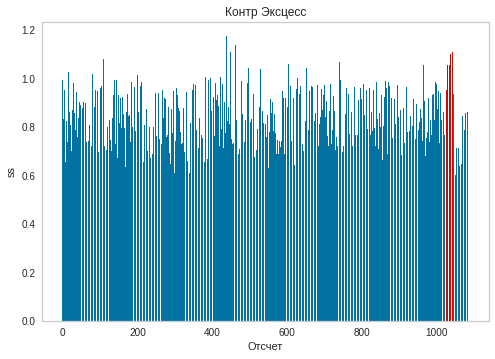

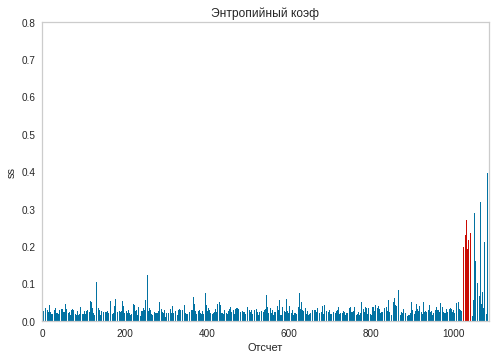

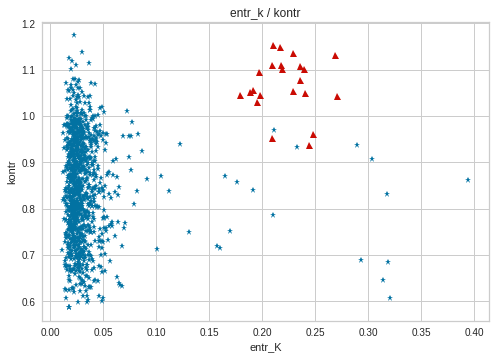

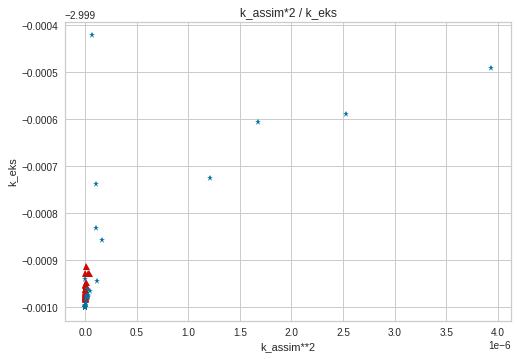

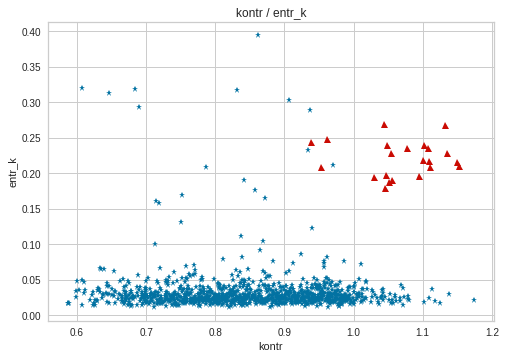

In [69]:
button6.on_click(on_button_clicked6) 
display(button6) 

# ГРАФИКИ ДЛЯ МАКСИМАЛЬНОЙ ДЛИНЫ ПАКЕТА

In [70]:
button7.on_click(on_button_clicked7) 
display(button7) 

Button(button_style='success', description='Графики для максимальной длины пакета', layout=Layout(height='80px…

# ГРАФИКИ ДЛЯ МИНИМАЛЬНОЙ ДЛИНЫ ПАКЕТА

In [71]:
button8.on_click(on_button_clicked8) 
display(button8)

Button(button_style='success', description='Графики для минимальной длины пакета', layout=Layout(height='80px'…

# ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ АДРЕСОВ IP ПАКЕТА

In [72]:
button9.on_click(on_button_clicked9) 
display(button9) 

Button(button_style='success', description='Графики для уникальных адресов ip пакета', layout=Layout(height='8…

# ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ ПОРТОВ IP ПАКЕТА

Button(button_style='success', description='Графики для уникальных портов ip пакета', layout=Layout(height='80…

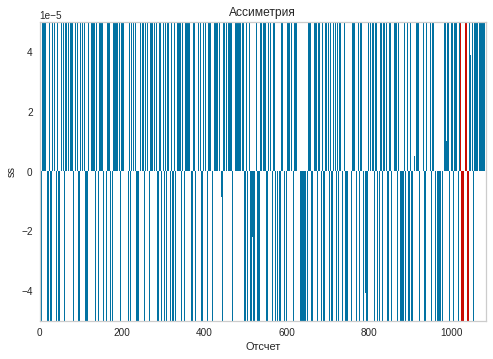

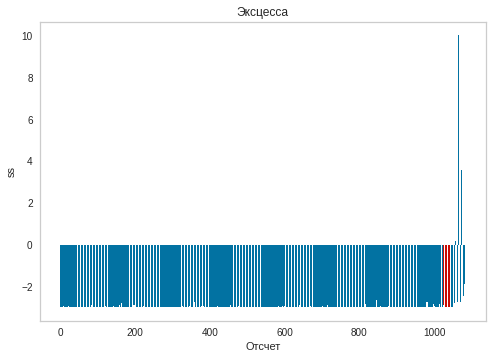

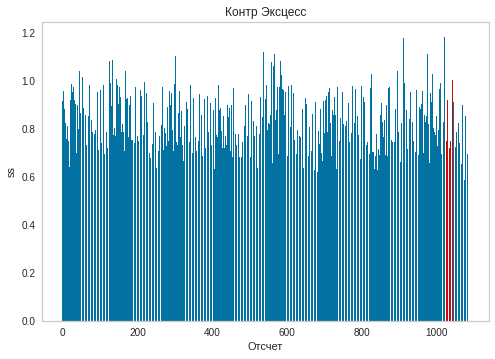

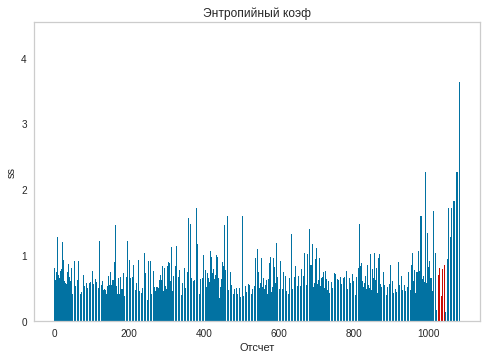

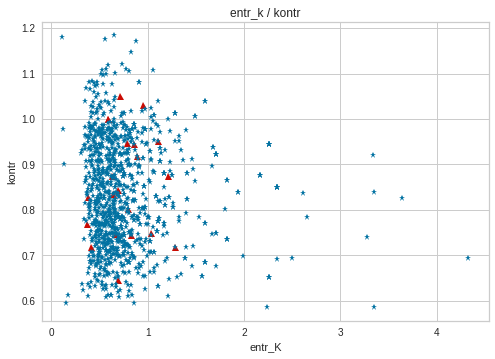

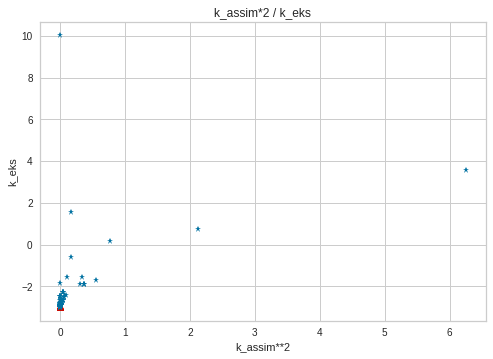

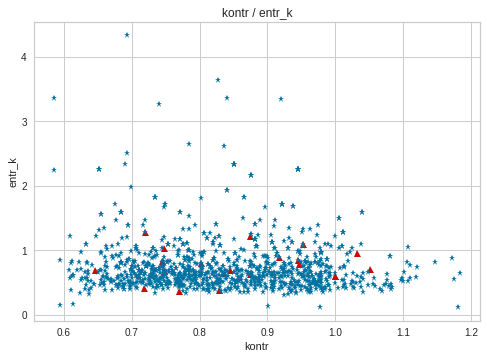

In [73]:
button10.on_click(on_button_clicked10) 
display(button10) 

# ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ ПАКЕТОВ

Button(button_style='success', description='Графики для интенсивности пакетов', layout=Layout(height='80px', w…

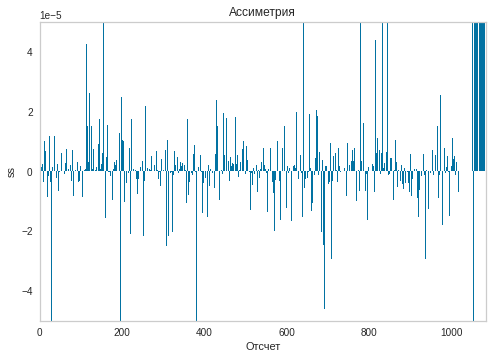

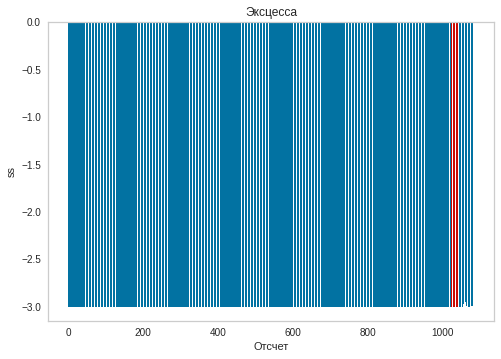

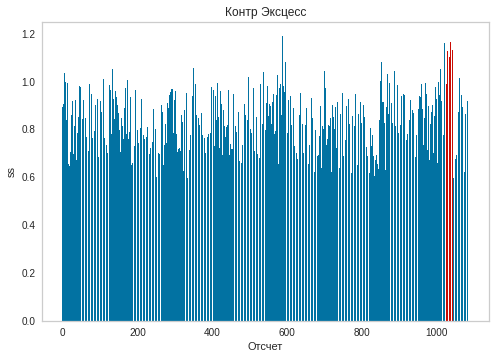

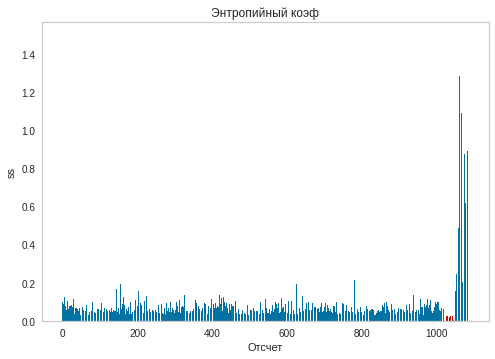

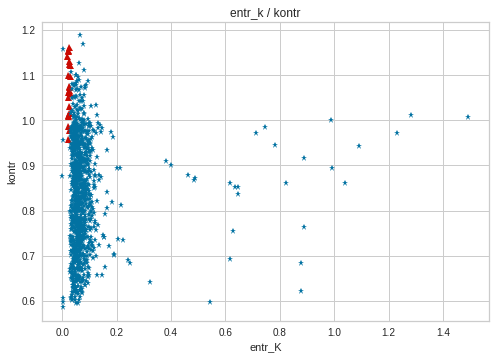

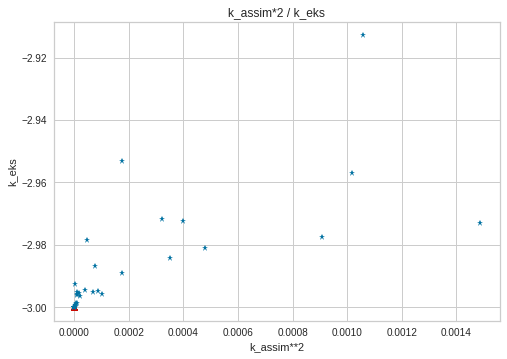

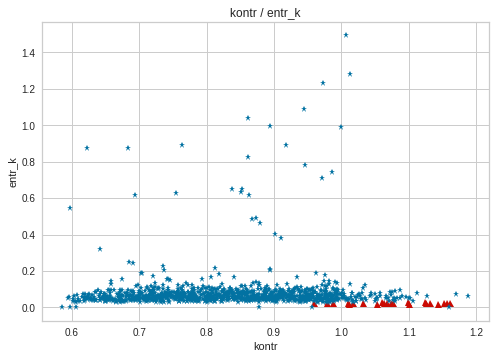

In [74]:
button11.on_click(on_button_clicked11) 
display(button11) 

# ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ БИТ

In [75]:
button12.on_click(on_button_clicked12) 
display(button12) 

Button(button_style='success', description='Графики для интенсивности бит', layout=Layout(height='80px', width…

# ИСПОЛЬЗОВАНИЕ PYCARET
СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


In [76]:
button13.on_click(on_button_clicked13)
display(button13)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0850
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0600
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0625
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0725
dt,Decision Tree Classifier,0.9987,0.9993,1.0000,0.9500,0.9722,0.9716,0.9730,0.0125
lightgbm,Light Gradient Boosting Machine,0.9960,0.9997,0.8750,0.9500,0.9008,0.8988,0.9049,0.0500
lda,Linear Discriminant Analysis,0.9947,0.9980,1.0000,0.8167,0.8944,0.8918,0.8990,0.0125
nb,Naive Bayes,0.9895,1.0000,1.0000,0.7667,0.8429,0.8382,0.8586,0.0150
svm,SVM - Linear Kernel,0.9895,0.0000,0.5000,0.7500,0.5952,0.5927,0.6077,0.0175
knn,K Neighbors Classifier,0.9816,0.9368,0.1250,0.5000,0.2000,0.1974,0.2480,0.0225


# ПРОВЕРКА SVM 

In [77]:
button14.on_click(on_button_clicked14) 
display(button14)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9868,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9868,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9868,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9737,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.9867,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


SGDClassifier(alpha=0.2, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.5, fit_intercept=True, l1_ratio=0.1300000001,
              learning_rate='invscaling', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=5521, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9816,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


# ПРОВЕРКА RANDOM FOREST



In [78]:
button15.on_click(on_button_clicked15) 
display(button15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9969,1.0000,1.0000,0.8571,0.9231,0.9215,0.9244


# ПРОВЕРКА KNN

In [79]:
button16.on_click(on_button_clicked16) 
display(button16)

Button(button_style='success', description='Использование методов KNN', layout=Layout(height='80px', width='50…

# TREE OF DECISION

In [80]:
button17.on_click(on_button_clicked17) 
display(button17)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9868,1.0000,1.0000,0.6667,0.8000,0.7935,0.8110
8,0.9868,1.0000,0.5000,1.0000,0.6667,0.6607,0.7024
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=5521, splitter='best')


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9939,0.9969,1.0000,0.7500,0.8571,0.8541,0.8633


In [62]:
 # dff = pd.read_csv('last.csv')
dataset = dff
dataset = shuffle(dataset)
     # print(dataset)

        # print(dataset.shape)
data = dataset.sample(frac=0.6, random_state=1234567)
data_unseen = dataset.drop(data.index)
data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

exp1 = setup(dff, target="classif")
compare_models(fold=4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9988,1.0000,1.0000,0.9500,0.9722,0.9716,0.9731,0.0150
dt,Decision Tree Classifier,0.9965,0.9982,1.0000,0.8667,0.9222,0.9205,0.9262,0.0100
gbc,Gradient Boosting Classifier,0.9965,0.9982,1.0000,0.8667,0.9222,0.9205,0.9262,0.0725
ada,Ada Boost Classifier,0.9953,0.9994,0.9375,0.8667,0.8865,0.8842,0.8922,0.0525
et,Extra Trees Classifier,0.9953,1.0000,0.7500,1.0000,0.8452,0.8430,0.8579,0.0700
lightgbm,Light Gradient Boosting Machine,0.9953,1.0000,0.9375,0.8667,0.8865,0.8842,0.8922,0.0300
rf,Random Forest Classifier,0.9941,1.0000,0.8750,0.8667,0.8389,0.8361,0.8521,0.0900
svm,SVM - Linear Kernel,0.9823,0.0000,0.3125,0.8000,0.4222,0.4147,0.4759,0.0125
lr,Logistic Regression,0.9811,0.8130,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
knn,K Neighbors Classifier,0.9811,0.6141,0.0000,0.0000,0.0000,0.0000,0.0000,0.0225


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)